Notebook showing usage of the data detective package.

In [1]:
# To import detective from relative folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import detective.core as detective
import detective.helpers as helpers
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress chained_assignment warning, default='warn'
import seaborn as sns
from sqlalchemy import text
import matplotlib.pyplot as plt
%matplotlib inline

To load from a local db, we just need the path

In [2]:
db_path = 'Users/robincole/Documents/Home-assistant_database/home-assistant_v2.db'
DB_URL = 'sqlite:////' + db_path

Alternatively, to load from a cloud database we load from a json file containing the url as the url contains our credentials and we want to lkeep these a secret. To learn how the Google CLoud SQL recorder can be setup checkout https://github.com/robmarkcole/HASS-Google-Cloud-SQL

In [3]:
# For cloud database with secret credentials, load from json. Time to load vaires, up to 3 mins.
#filename = '/Users/robincole/Desktop/hass_db_url.json'
#DB_URL = helpers.load_url(filename)

## Load the db data

We use the DataParser class to load data from the database. This class performs the SQL queries and parses the returned data. The class holds the master pandas dataframe master_df.

In [4]:
%%time
db = detective.HassDatabase(DB_URL) # To init without fetching entities fetch_entities=False

Successfully connected to sqlite:////Users/robincole/Documents/Home-assistant_database/home-assistant_v2.db
There are 261 entities with data
CPU times: user 540 ms, sys: 2.59 s, total: 3.13 s
Wall time: 13.5 s


In [5]:
db.domains

['binary_sensor',
 'automation',
 'sun',
 'light',
 'input_select',
 'updater',
 'group',
 'zone',
 'switch',
 'sensor',
 'alarm_control_panel',
 'script',
 'device_tracker',
 'camera',
 'remote',
 'media_player',
 'persistent_notification']

In [6]:
db.entities['binary_sensor']

['binary_sensor.motion_at_home',
 'binary_sensor.living_room_motion_sensor',
 'binary_sensor.in_bed_bayesian',
 'binary_sensor.hall_motion_sensor',
 'binary_sensor.bedroom_motion_sensor',
 'binary_sensor.blink_armed_status',
 'binary_sensor.blink_blink_camera_percy_motion_enabled',
 'binary_sensor.workday_sensor',
 'binary_sensor.living_room_nest_protect_online',
 'binary_sensor.bayesianbinary']

In [7]:
db.entities['sensor'][15:20]

['sensor.living_room_temperature',
 'sensor.hall_light_sensor',
 'sensor.home_to_waterloo',
 'sensor.work_to_home',
 'sensor.living_room_light_sensor']

## Simple query

Lets query a single sensor and demonstrate the data processing steps implemented by the library

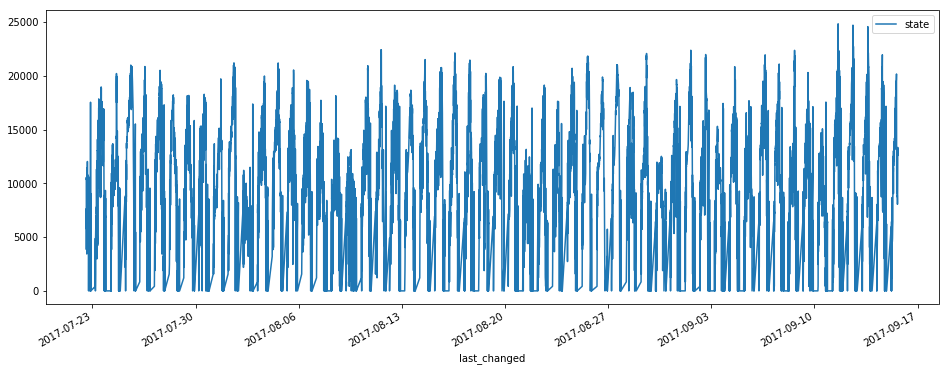

In [8]:
query = text(
    """
    SELECT state, last_changed
    FROM states
    WHERE entity_id in ('sensor.hall_light_sensor') 
    AND NOT state='unknown'
    """
    )
response = db.perform_query(query)
df = pd.DataFrame(response.fetchall()) # Convert to dataframe
df.columns = ['state', 'last_changed'] # Set the columns
df = df.set_index('last_changed') # Set the index on datetime
df.index = pd.to_datetime(df.index) # Convert string to datetime
df = df.mask(df.eq('None')).dropna().astype(float) #  Convert state strings to floats for plotting
df.plot(figsize=(16, 6));

## Helper to query by list
Use `fetch_data_by_list` to query a list of numerical entities, must be from same domain. Returns a pandas dataframe.

In [9]:
db.fetch_data_by_list()  # Need to fix this error

Error with query: 
            SELECT entity_id, state, last_changed
            FROM states
            WHERE entity_id in (sensor.living_room_temperature)
            AND NOT state='unknown'
            


AttributeError: 'NoneType' object has no attribute 'fetchall'

In [12]:
len(entities)

30

In [17]:
def fetch_data_by_list(*args):
    entities = []
    for arg in args:
        entities += helpers.ensure_list(arg)
    print(entities)
    if len(entities) == 1:
        entities_query = '({})'.format(entities[0])
    else:
        entities_query = tuple(entities)
    return entities_query

In [20]:
fetch_data_by_list(db.entities['sensor'][15])

['sensor.living_room_temperature']


'(sensor.living_room_temperature)'

In [11]:
entities_query

('s',
 'e',
 'n',
 's',
 'o',
 'r',
 '.',
 'l',
 'i',
 'v',
 'i',
 'n',
 'g',
 '_',
 'r',
 'o',
 'o',
 'm',
 '_',
 't',
 'e',
 'm',
 'p',
 'e',
 'r',
 'a',
 't',
 'u',
 'r',
 'e')

In [ ]:
db.fetch_data_by_list(db.entities['sensor'][15:17]).head()

## Query all data
If you aren't in a rush, it can be convenient to query the entire db into a pandas dataframe

In [ ]:
%%time
db.fetch_all_data()

Lets create an object holding the numerical sensor

In [ ]:
sensors_num = detective.NumericalSensors(db.master_df)

We can access the list of sensor entities using the list_sensors attribute

In [ ]:
sensors_num.entities[0:10]

Now lets look at the dataframe

In [ ]:
sensors_num.data.head()

Lets now check for correlations in the data using the all_corrs() method

In [ ]:
corrs = sensors_num.correlations()

In [ ]:
corrs[(corrs['value'] > 0.75) | (corrs['value'] < -0.75)]

Unsurprisingly the mean temperature is strongly correlated with all of the temperature sensors. 

Interestingly my iphone battery level is somewhat inversely correlated with the travel time from home to waterloo, which gets longer late at night when my battery level is more likely to be low. 

#### Plot sensor data
Convenience to plot a sensor data.
Pass a single entity to plot:

In [ ]:
sensors_num.plot('sensor.darksky_sensor_temperature')

Lets save to csv

In [ ]:
darksky_temperature.to_csv('darksky_temperature.csv')

We can pass a list of entities to plot:

In [ ]:
to_plot = ['sensor.living_room_temperature',
           'sensor.bedroom_temperature',
           'sensor.darksky_sensor_temperature']

sensors_num.plot(to_plot)

Even mix up lists and single entites

In [ ]:
sensors_num.plot(to_plot, 'sensor.mean_temperature')

#### Pairplot
A seaborn pair plot to show correlations.

In [ ]:
sns.pairplot(sensors_num.data[to_plot]);

## Binary sensors
Class for handling binary sensors with on/off states.

In [ ]:
sensors_binary = detective.BinarySensors(db.master_df)

In [ ]:
sensors_binary.entities

Currently we can plot a single binary sensor with the plot() method

In [ ]:
sensors_binary.plot('binary_sensor.motion_at_home')

## Day of week analysis

Lets analyse the **motion_at_home**, create some features for day of week and time category, then analyse motion by these features.

In [ ]:
motion_df = sensors_binary.data[['binary_sensor.motion_at_home']] # Must pass a list to return correctly indexed df

In [ ]:
motion_df['weekday'] = motion_df.index.weekday_name

In [ ]:
motion_df['is_weekday'] = motion_df.index.map(lambda x: helpers.is_weekday(x))

In [ ]:
motion_df = motion_df[motion_df['binary_sensor.motion_at_home'] == True] # Keep only true detection events

In [ ]:
motion_df['time_category'] = motion_df.index.map(lambda x: helpers.time_category(x))

In [ ]:
motion_df.head()

In [ ]:
motion_df['binary_sensor.motion_at_home'].groupby(motion_df['is_weekday']).describe()['count']

In [ ]:
motion_df_gb = motion_df['binary_sensor.motion_at_home'].groupby([motion_df['weekday'], motion_df['time_category']]).sum().unstack()
motion_df_gb.fillna(value=0, inplace=True)   # Replace NaN with 0
motion_df_gb = motion_df_gb.astype('int')              # Ints rather than floats
motion_df_gb = motion_df_gb.T
motion_df_gb

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_list = ['morning', 'daytime', 'evening', 'night']
ax = sns.heatmap(motion_df_gb[days_list].loc[times_list], annot=True, linewidths=.5, fmt="d", ax=ax, cmap='Reds');
ax.set_title('Activity at home by day and time category')
#fig.savefig('heatmap.jpg')